# Imports and definition of helper functions
The first block imports all necessary packages, this should normally not be changed unless you want to build custom functions or networks.

The second block defines some helper functions. You might want to have a look here how they look, but everything should be fine as is.

**Don't forget to enable the GPU for your notebook if you want hardware acceleration**

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import h5py
from sklearn import metrics
from scipy import io as sio
from scipy import signal as sg
from sklearn import metrics
import seaborn as sns
import math

from sklearn.decomposition import PCA 
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Reshape, MaxPool1D, Activation, GlobalAveragePooling1D, Dense
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint

from google.colab import files

In [2]:
 def plot_performance_curves(y_true, y_proba, save_path=None):
  """
  Plot ROC-curve and PR-curve
  """
  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

  # ROC curve
  fpr, tpr, _ = metrics.roc_curve(y_true=y_true, y_score=y_proba)
  roc_auc = metrics.auc(fpr, tpr)

  lw = 2
  ax1.plot(fpr, tpr, color='C0', lw=lw,
            label='AUC = {0:.3f}'.format(roc_auc))
  ax1.plot([0, 1], [0, 1], color='C1', lw=lw, linestyle='--')
  ax1.set_xlim([0., 1.])
  ax1.set_ylim([0., 1.05])
  ax1.set_xlabel('1 - Specificity')
  ax1.set_ylabel('Sensitivity')
  ax1.set_title('Receiver Operating Characteristic')
  ax1.legend(loc='lower right')
  sns.despine(trim=True, ax=ax1)

  # PR curve
  prec, rec, _ = metrics.precision_recall_curve(y_true=y_true, probas_pred=y_proba)
  ap = metrics.average_precision_score(y_true=y_true, y_score=y_proba)

  ax2.plot(rec, prec, drawstyle='steps-post', label='AP = {0:.3f}'.format(ap))
  ax2.set_xlim([0., 1.])
  ax2.set_ylim([0., 1.])
  ax2.set_xlabel('Recall')
  ax2.set_ylabel('Precision')
  ax2.set_title('Precision-recall Curve')
  ax2.legend()
  sns.despine(trim=True, ax=ax2)

  if save_path:
    plt.savefig(save_path+'.pdf', bbox_inches='tight')

  plt.show()

# Upload data
Run this section to upload the `deeplearning_data.zip` file from Toledo. This will likely take a while.

In [3]:
uploaded = files.upload()

Saving deeplearning_data.zip to deeplearning_data.zip


In [4]:
!unzip deeplearning_data.zip

Archive:  deeplearning_data.zip
  inflating: classical_features.npy  
  inflating: classical_labels.npy    
  inflating: x_test.npy              
  inflating: x_train.npy             
  inflating: y_test.npy              
  inflating: y_train.npy             


# Data loading and normalization
Here we go from the `npy` files to usable Numpy arrays. The first block loads all necessary arrays into memory.

The second one performs data normalization by default. You can disable data normalization by running this section again and setting the `normalize` variable to `False`. Every recording is individually rescaled to unit variance. Feel free to change to a different normalization scheme but document this clearly in your report.

In [5]:
x_train = np.load('x_train.npy')
y_train = np.load('y_train.npy')

x_test = np.load('x_test.npy')
y_test = np.load('y_test.npy')

classical_features = np.load('classical_features.npy')
classical_labels = np.load('classical_labels.npy')

In [6]:
normalize = True

if normalize:
  train_mean = np.mean(x_train, axis=-1, keepdims=True)
  train_std = np.std(x_train, axis=-1, keepdims=True)
  test_mean = np.mean(x_test, axis=-1, keepdims=True)
  test_std = np.std(x_test, axis=-1, keepdims=True)

  x_train = (x_train - train_mean) / train_std
  x_test = (x_test - test_mean) / test_std

# Data 'exploration'
Some example plots + label distribution

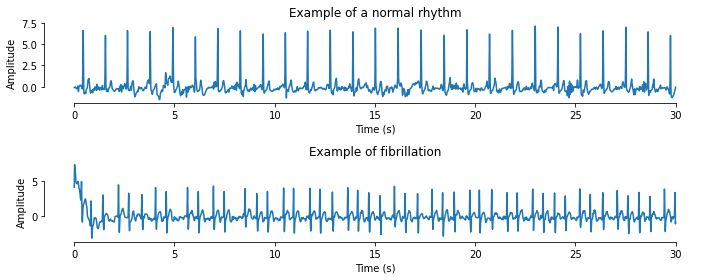

In [7]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,4))

index_normal = np.where(y_train==0)[0][0]
index_af = np.where(y_train==1)[0][2]

ax1.plot(np.linspace(0, 30, 6000), x_train[index_normal])
sns.despine(trim=True, ax=ax1)
ax1.set_title('Example of a normal rhythm')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude')

ax2.plot(np.linspace(0, 30, 6000), x_train[index_af])
sns.despine(trim=True, ax=ax2)
ax2.set_title('Example of fibrillation')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Amplitude')

plt.tight_layout()
plt.show()

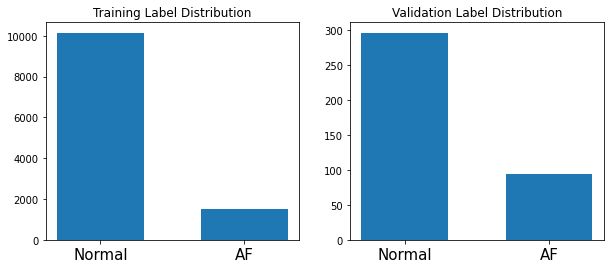

In [8]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

ax1.bar(x=[0, 1], height=[np.sum(y_train==0), np.sum(y_train==1)], width=0.6)
ax1.set_xticks([0,1])
ax1.set_xticklabels(['Normal', 'AF'], size=15)
ax1.set_title('Training Label Distribution', size=12)

ax2.bar(x=[0, 1], height=[np.sum(y_test==0), np.sum(y_test==1)], width=0.6)
ax2.set_xticks([0,1])
ax2.set_xticklabels(['Normal', 'AF'], size=15)
ax2.set_title('Validation Label Distribution', size=12)

plt.show()

# Constructing the neural network
Use this section to build your own neural network. You can follow any basic Keras tutorial, just remember we are working with time series instead of images. (So, use `Conv1D` instead of `Conv2D`)

The function below assumes use of the `Functional` API. Many Keras tutorials start out with its `Sequenctial` API, but this way of building networks can easily become too limiting once you move away from simple networks.

The main way of building a network in the `Functional` API is "chaining" together different layers. In Python code, this follows the template of 
```
new_layer = <Layer_Type>(layer_parameters)(previous_layer)
```
You can chain various layer types together this way, and branch out or combine them. The default building block for most CNNs these days is to use a chain of convolution (without activation) -> batch normalization -> ReLU (-> pooling). You can start out with a few of these blocks, or try something else.

In [25]:
def build_cnn():
 input_length = 6000
 input_signal = Input(shape=(input_length,))
 x = Reshape(target_shape=(input_length, 1))(input_signal)

 #################################################
 # BUILD YOUR NETWORK HERE
 # You can rely on the `GlobalAveragePooling1D`
 # below, or implement your own pooling operation
 # to go to a feature representation.

 x = Conv1D(filters=64,kernel_size=3, activation=None)(x) 
 x = BatchNormalization()(x) #normalizes inputs
 x = Conv1D(filters=64,kernel_size=3, activation=None)(x) 
 x = BatchNormalization()(x) #normalizes inputs
 x = Conv1D(filters=64,kernel_size=3, activation=None)(x)
 x = BatchNormalization()(x) #normalizes inputs

 x = GlobalAveragePooling1D()(x)
 #################################################
  
 

 output = Dense(units=1, activation='sigmoid')(x)

 clf = Model(input_signal, output)
 feature_extraction = Model(input_signal, x)

 return clf, feature_extraction

In [26]:
clf, feature_extraction = build_cnn()

In [27]:
clf.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 6000)]            0         
                                                                 
 reshape_1 (Reshape)         (None, 6000, 1)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 5998, 64)          256       
                                                                 
 batch_normalization_2 (Batc  (None, 5998, 64)         256       
 hNormalization)                                                 
                                                                 
 conv1d_3 (Conv1D)           (None, 5996, 64)          12352     
                                                                 
 batch_normalization_3 (Batc  (None, 5996, 64)         256       
 hNormalization)                                           

# Training the network
Some parameters to influence the training process. Calling `clf.fit()` starts the training process and outputs a `History` object containing variables that Keras tracks during training.

- `n_epochs`
- `batch_size`
- `lr_init` initial learning rate
- `opt` is an instance of a Keras optimizer. `tf.keras.optimizers` contains other optimizers you can try.
- `loss` By default the cross-entropy loss. You probably do not want to change this.
- `metrics` A python list of strings, containing metrics specified in `tf.keras.metrics`. Think about what other metrics might be interesting to track during training. Keep in mind that this an unbalanced data set.
- `use_decay`, A boolean telling whether or not to use learning rate decay.

In [28]:
n_epochs = 200
batch_size = 128
lr_init = 1e-3

opt = tf.keras.optimizers.Adam(lr=lr_init)

loss = 'binary_crossentropy'
training_metrics = ['accuracy']

use_decay = False

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [29]:
def scheduler_function(epoch, lr):
  return np.float32(lr_init * math.pow(0.5, epoch//20))
scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler_function)

In [30]:
clf.compile(optimizer=opt, loss=loss, metrics=training_metrics)

In [ ]:
if use_decay:
  history = clf.fit(x=x_train, y=y_train,
                    validation_data=(x_test, y_test),
                    batch_size=batch_size, epochs=n_epochs,
                    callbacks=[scheduler])
else:
  history = clf.fit(x=x_train, y=y_train,
                    validation_data=(x_test, y_test),
                    batch_size=batch_size, epochs=n_epochs)

Epoch 1/200
92/92 [==============================] - 42s 438ms/step - loss: 0.5313 - accuracy: 0.8660 - val_loss: 0.5559 - val_accuracy: 0.7590
Epoch 2/200
92/92 [==============================] - 40s 437ms/step - loss: 0.3900 - accuracy: 0.8701 - val_loss: 0.5970 - val_accuracy: 0.7590
Epoch 3/200
92/92 [==============================] - 40s 433ms/step - loss: 0.3864 - accuracy: 0.8701 - val_loss: 0.5957 - val_accuracy: 0.7590
Epoch 4/200
92/92 [==============================] - 40s 435ms/step - loss: 0.3863 - accuracy: 0.8701 - val_loss: 0.5940 - val_accuracy: 0.7590
Epoch 5/200
92/92 [==============================] - 40s 436ms/step - loss: 0.3864 - accuracy: 0.8701 - val_loss: 0.5975 - val_accuracy: 0.7590
Epoch 6/200
92/92 [==============================] - 40s 436ms/step - loss: 0.3864 - accuracy: 0.8701 - val_loss: 0.5952 - val_accuracy: 0.7590
Epoch 7/200
92/92 [==============================] - 40s 433ms/step - loss: 0.3863 - accuracy: 0.8701 - val_loss: 0.6008 - val_accuracy:

# Assessing results

In [1]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

NameError: ignored

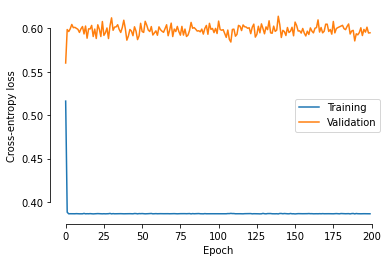

In [17]:
plt.plot(training_loss, label='Training')
plt.plot(validation_loss, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Cross-entropy loss')
plt.legend()
sns.despine(trim=True)
plt.savefig('loss.pdf', bbox_inches='tight')
plt.show()

In [18]:
y_proba = clf.predict(x_test)
y_pred = y_proba > 0.5

In [19]:
acc = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
f1 = metrics.f1_score(y_true=y_test, y_pred=y_pred)
print('Accuracy:    {0:.3f}'.format(acc))
print('F1-score:    {0:.3f}'.format(f1))

Accuracy:    0.759
F1-score:    0.000


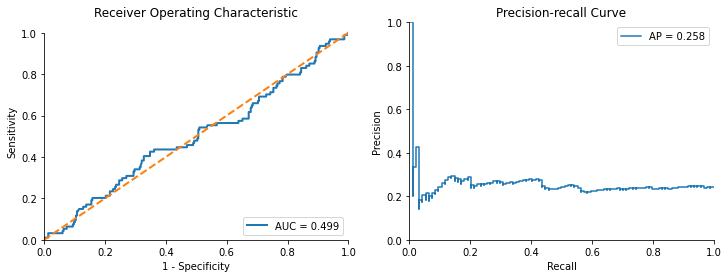

In [20]:
plot_performance_curves(y_true=y_test, y_proba=y_proba)

# Investigating the feature space

In [21]:
pca = PCA(n_components=2)
tsne = TSNE(n_components=2)

We give you the feature space plots of classical features as example. The classical feature arrays also contain entries for the other classes in the dataset, these should be filtered out first. The first two 'features' in the `classical_features` array do not contain meaningful features but are leftovers from the feature extraction process. They should be ignored.

In [22]:
idx = np.logical_or(classical_labels==0, classical_labels==1)

classical_pca = pca.fit_transform(classical_features[idx, 2:])
classical_tsne = tsne.fit_transform(classical_features[idx, 2:])

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


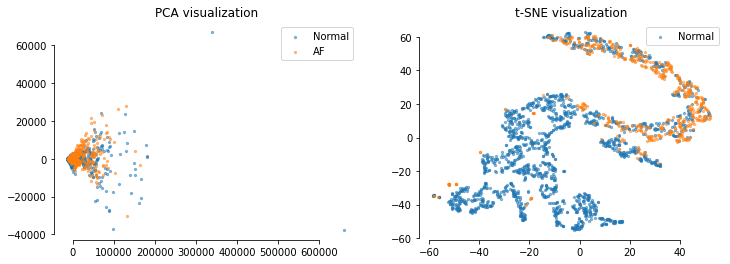

In [23]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

normal_idx = classical_labels[idx] == 0
af_idx = classical_labels[idx] == 1

ax1.scatter(classical_pca[normal_idx, 0], classical_pca[normal_idx, 1], label='Normal', s=5, alpha=0.5)
ax1.scatter(classical_pca[af_idx, 0], classical_pca[af_idx, 1], label='AF', s=5, alpha=0.5)
ax1.legend()
sns.despine(trim=True, ax=ax1)
ax1.set_title('PCA visualization')

ax2.scatter(classical_tsne[normal_idx, 0], classical_tsne[normal_idx, 1], label='Normal', s=5, alpha=0.5)
ax2.scatter(classical_tsne[af_idx, 0], classical_tsne[af_idx, 1], s=5, alpha=0.5)
ax2.legend()
sns.despine(trim=True, ax=ax2)
ax2.set_title('t-SNE visualization')

plt.show()

Try and visualize the feature space of your final model in a similar way. The `feature_extraction` model gives you the activations of your complete classifier before the final dense layer using the learned network weights.

In [24]:
f = feature_extraction.predict(x_test)